## Семинар 2 "Распознавание рукописных цифр"

ФИО: Новак Александр Вадимович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации.

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

# I hadn't enough patience to wait for custom layers on cpu => torch on gpu))
from torch import nn, optim
from torch.autograd import Function
from torch import no_grad, max
from torch import Tensor
from torch.utils.data import TensorDataset
from torch import device, cuda
import torch

DEVICE = device("cuda:0" if cuda.is_available() else "cpu")

import numpy as np
import sys
from IPython.display import clear_output
%matplotlib inline

In [2]:
def plot_train_results(loss_results: list, acc_results: list, labels: list) -> None:
    """plots loss and accuracy from given lists"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    for loss_result, label in zip(loss_results, labels):
        plt.plot(loss_result, label=label)

    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    for acc_result, label in zip(acc_results, labels):
        plt.plot(acc_result, label=label)

    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()
    plt.show()

In [3]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
train_dataset = TensorDataset(train_dataset.train_data.to(DEVICE, dtype = torch.float),
                              train_dataset.train_labels.to(DEVICE))

test_dataset = MNIST('.', train=False, transform=transform)
test_dataset = TensorDataset(test_dataset.test_data.to(DEVICE, dtype = torch.float),
                              test_dataset.test_labels.to(DEVICE))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 151534311.02it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 106352672.37it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 72704723.32it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19242958.35it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw




/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
X, y = next(iter(train_loader))
X = X.to("cpu").numpy()
y = y.to("cpu").numpy()

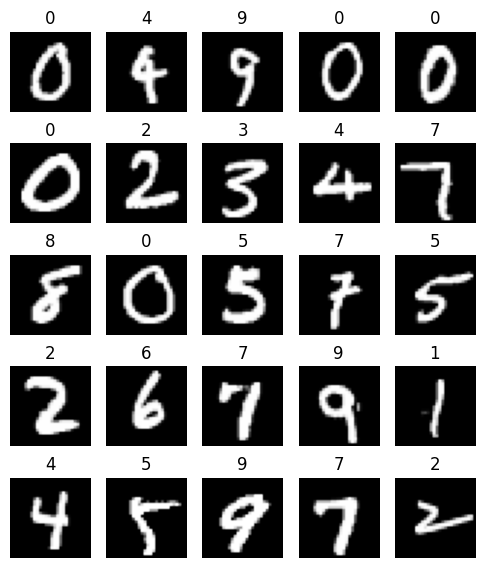

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите LEARNING_RATE

In [44]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.0005

In [7]:
def train_and_evaluate(model, train_loader: DataLoader, test_loader: DataLoader,
                       num_epochs: int = NUM_EPOCHS, learning_rate = LEARNING_RATE):
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        test_loss = 0.0
        test_accuracy = 0.0
        for _, (inputs, targets) in enumerate(train_loader):
            outputs = model(inputs)
            curr_loss = loss(outputs, targets)

            optimizer.zero_grad()
            curr_loss.backward()
            optimizer.step()

            _, predicted = max(outputs.data, 1)
            accuracy = (predicted == targets).float().mean() * 100.0

            train_loss += curr_loss.item()
            train_accuracy += accuracy.item()

        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)

        print(f"{epoch=} {train_loss=} {train_accuracy=}")

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        with no_grad():
            for _, (inputs, targets) in enumerate(test_loader):
                outputs = model(inputs)
                _, predicted = max(outputs.data, 1)
                test_loss += loss(outputs, targets).item()
                test_accuracy += (predicted == targets).float().mean() * 100.0

            test_loss /= len(test_loader)
            test_accuracy /= len(test_loader)

            test_losses += [test_loss]
            test_accuracies += [test_accuracy]

    train_losses = Tensor(train_losses).cpu().tolist()
    test_losses = Tensor(test_losses).cpu().tolist()
    train_accuracies = Tensor(train_accuracies).cpu().tolist()
    test_accuracies = Tensor(test_accuracies).cpu().tolist()

    plot_train_results(loss_results=[train_losses, test_losses], acc_results=[train_accuracies, test_accuracies],
                       labels=["Train", "Test"])
    return train_losses, test_losses, train_accuracies, test_accuracies

In [8]:
network_s = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.Sigmoid(),
    nn.Linear(100, 100),
    nn.Sigmoid(),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch=0 train_loss=1.7952070501327515 train_accuracy=70.01833333333333
epoch=1 train_loss=1.632135313987732 train_accuracy=84.69
epoch=2 train_loss=1.5896260000228881 train_accuracy=88.24666666666667
epoch=3 train_loss=1.5845517948786418 train_accuracy=88.495
epoch=4 train_loss=1.5758742556254068 train_accuracy=89.295
epoch=5 train_loss=1.5771803202311199 train_accuracy=89.055
epoch=6 train_loss=1.5693212613423666 train_accuracy=89.70333333333333
epoch=7 train_loss=1.5610422889709472 train_accuracy=90.29666666666667
epoch=8 train_loss=1.5649946763356526 train_accuracy=90.0
epoch=9 train_loss=1.5581918162663777 train_accuracy=90.66166666666666


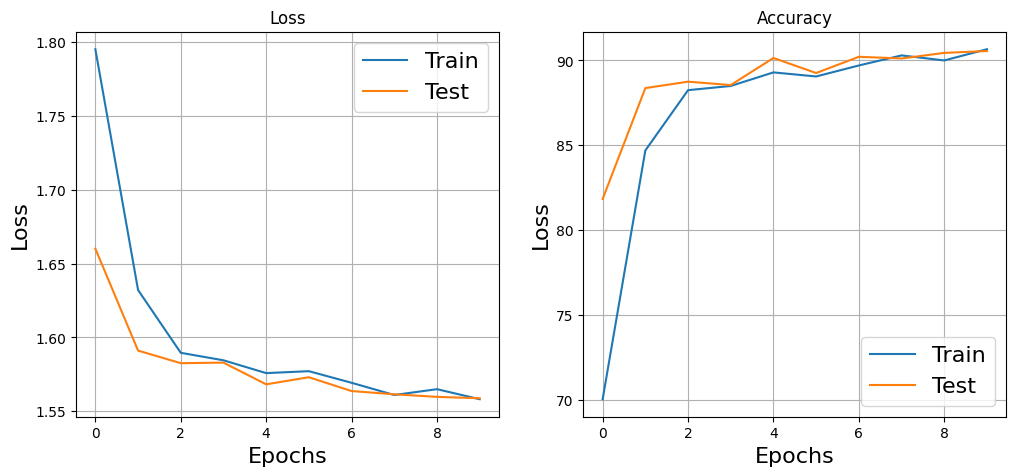

In [9]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train_and_evaluate(network_s, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE)

### Часть 2: Нелинейности

In [10]:
class ActivationWrapper(nn.Module):
    def __init__(self, activation: Function):
        super(ActivationWrapper, self).__init__()
        self.activation = activation

    def forward(self, input):
        return self.activation.apply(input)

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [11]:
class ReLU(Function):
    @staticmethod
    def forward(ctx, X):
        ctx.save_for_backward(X)
        return X.clamp(min = 0)

    @staticmethod
    def backward(ctx, dLdy):
        X, = ctx.saved_tensors
        return dLdy * (X > 0)


In [12]:
class ELU(Function):
    @staticmethod
    def forward(ctx, X):
        a = 1
        ctx.save_for_backward(X)
        return torch.where(X > 0, X, a * (torch.exp(X) - 1))

    @staticmethod
    def backward(ctx, dLdy):
        a = 1
        X, = ctx.saved_tensors
        dydX = torch.where(X > 0, torch.ones_like(X), a * torch.exp(X))
        return dLdy*dydX

epoch=0 train_loss=1.5896223985036215 train_accuracy=87.11666666666666
epoch=1 train_loss=1.542437609799703 train_accuracy=91.86166666666666
epoch=2 train_loss=1.5369468519846599 train_accuracy=92.38
epoch=3 train_loss=1.5344899342219034 train_accuracy=92.645
epoch=4 train_loss=1.5316027592341106 train_accuracy=92.93666666666667
epoch=5 train_loss=1.530311197344462 train_accuracy=93.05833333333334
epoch=6 train_loss=1.5284191285451254 train_accuracy=93.265
epoch=7 train_loss=1.535403809928894 train_accuracy=92.56
epoch=8 train_loss=1.5283469175338744 train_accuracy=93.26666666666667
epoch=9 train_loss=1.5277478701909384 train_accuracy=93.33666666666667


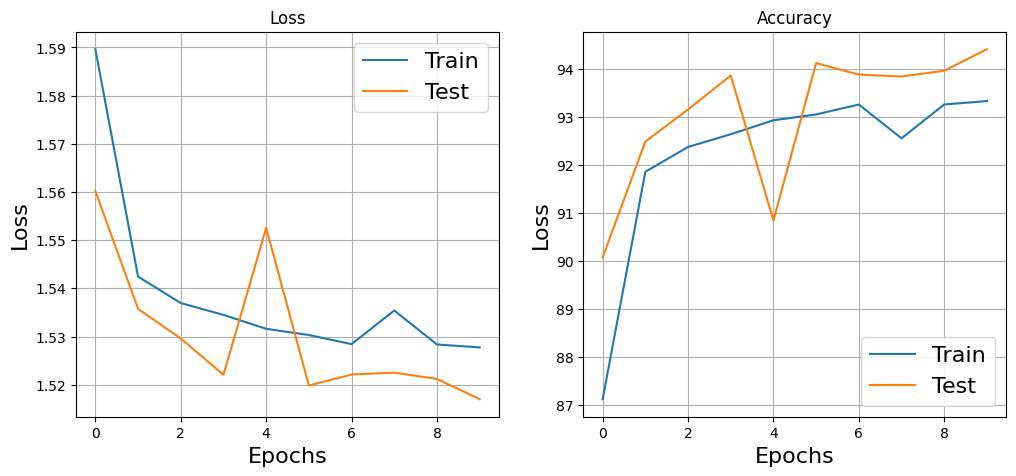

In [45]:
network_r = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    ActivationWrapper(ReLU()),
    nn.Linear(100, 100),
    ActivationWrapper(ReLU()),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)

tr_r, ts_r, tr_ac_r, ts_ac_r = train_and_evaluate(network_r, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE)

epoch=0 train_loss=1.6839619445165 train_accuracy=77.61166666666666
epoch=1 train_loss=1.628856805419922 train_accuracy=83.16833333333334
epoch=2 train_loss=1.5861769154230754 train_accuracy=87.47666666666667
epoch=3 train_loss=1.5442329563776651 train_accuracy=91.685
epoch=4 train_loss=1.5430953625996908 train_accuracy=91.795
epoch=5 train_loss=1.5359788181304932 train_accuracy=92.49
epoch=6 train_loss=1.5340567309061686 train_accuracy=92.69333333333333
epoch=7 train_loss=1.5286539253870646 train_accuracy=93.24333333333334
epoch=8 train_loss=1.5287538937250773 train_accuracy=93.235
epoch=9 train_loss=1.5284884882609049 train_accuracy=93.25833333333334


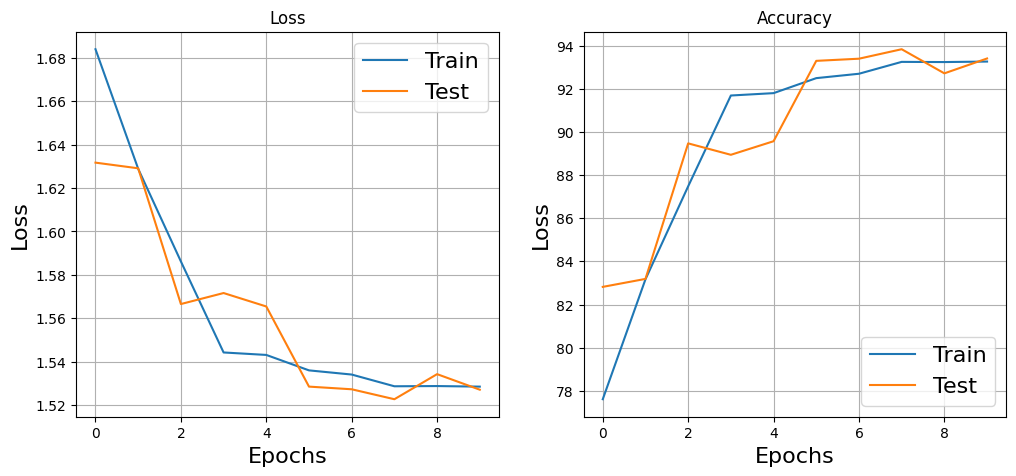

In [47]:
network_e = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    ActivationWrapper(ELU()),
    nn.Linear(100, 100),
    ActivationWrapper(ELU()),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE, dtype = torch.float)

tr_e, ts_e, tr_ac_e, ts_ac_e = train_and_evaluate(network_e, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE)

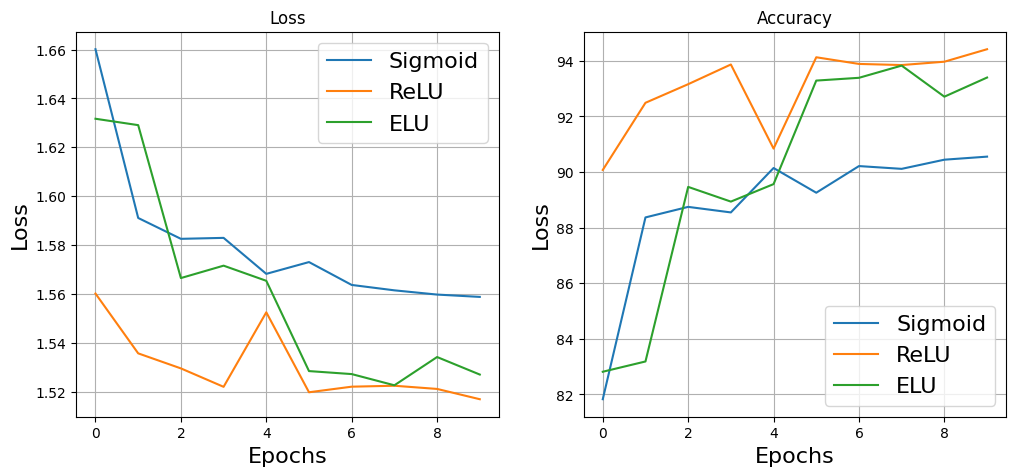

In [48]:
plot_train_results(loss_results=[ts_s, ts_r, ts_e], acc_results=[ts_ac_s, ts_ac_r, ts_ac_e],
                       labels=["Sigmoid", "ReLU", "ELU"])

ELU и ReLU сходятся лучше, чем сигмоида.
Однако стоит отметить, что с оптимизатором adam pytorch показывает гораздо более хорошие результаты с learning rate гораздо меньше 0.01 (как с встроенными функциями активации, так и с самодельными. При этом ReLU и ELU с 0.01 показывали точность обычно порядка 40%, а при 0.001 сильно зависили от инициализации).

### HW1 (1 балл): Реализовать Tanh

In [16]:
class Tanh(Function):
    '''
    Tanh(x) = (e^(2x) - 1) / (e^(2x) + 1)
    '''
    @staticmethod
    def forward(ctx, X):
        result = 2 / (1 + torch.exp(-2 * X)) - 1
        ctx.save_for_backward(result)
        return result

    @staticmethod
    def backward(ctx, dLdy):
        result, = ctx.saved_tensors
        return dLdy * (1 - result * result)

epoch=0 train_loss=1.6722954763412476 train_accuracy=83.195
epoch=1 train_loss=1.6026274444580078 train_accuracy=87.23
epoch=2 train_loss=1.5891173250198365 train_accuracy=88.02666666666667
epoch=3 train_loss=1.5781305667877197 train_accuracy=89.00333333333333
epoch=4 train_loss=1.570696792602539 train_accuracy=89.615
epoch=5 train_loss=1.5654650651931763 train_accuracy=90.04
epoch=6 train_loss=1.5659225382486979 train_accuracy=89.93
epoch=7 train_loss=1.5584651847839355 train_accuracy=90.64166666666667
epoch=8 train_loss=1.5540662464777628 train_accuracy=90.93166666666667
epoch=9 train_loss=1.556580210940043 train_accuracy=90.77166666666666


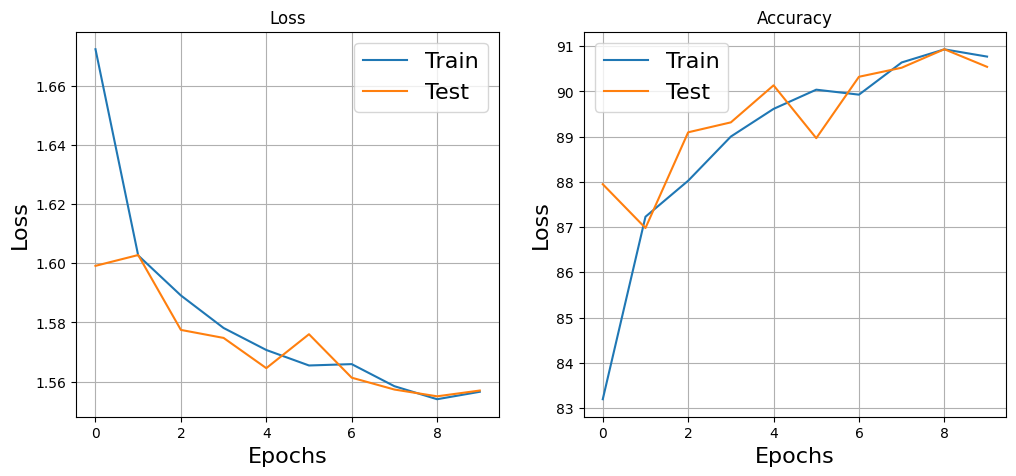

In [49]:
network_t = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    ActivationWrapper(Tanh()),
    nn.Linear(100, 100),
    ActivationWrapper(Tanh()),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)

tr_t, ts_t, tr_ac_t, ts_ac_t = train_and_evaluate(network_t, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE)

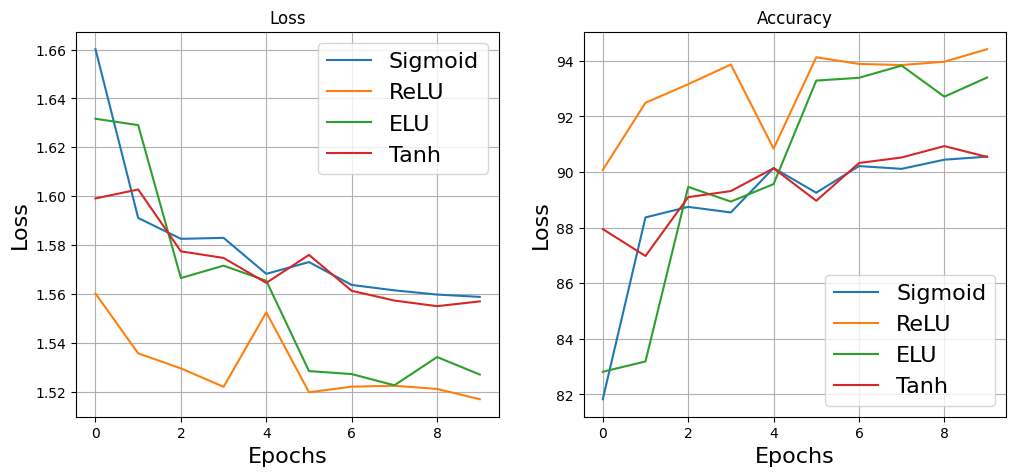

In [50]:
plot_train_results(loss_results=[ts_s, ts_r, ts_e, ts_t],
                        acc_results=[ts_ac_s, ts_ac_r, ts_ac_e, ts_ac_t],
                        labels=["Sigmoid", "ReLU", "ELU", "Tanh"])

### Часть 3: Анализ ошибок

In [51]:
from torch import argmax

wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).to(DEVICE)
    y = y.to(DEVICE)
    prediction = network_t.forward(X)
    prediction = torch.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i].cpu().numpy())
            correct_y.append(y[i].cpu().numpy())
            predicted_y.append(argmax(prediction[i]).cpu().numpy())
            logits.append(prediction[i][y[i]].cpu().detach().numpy())
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

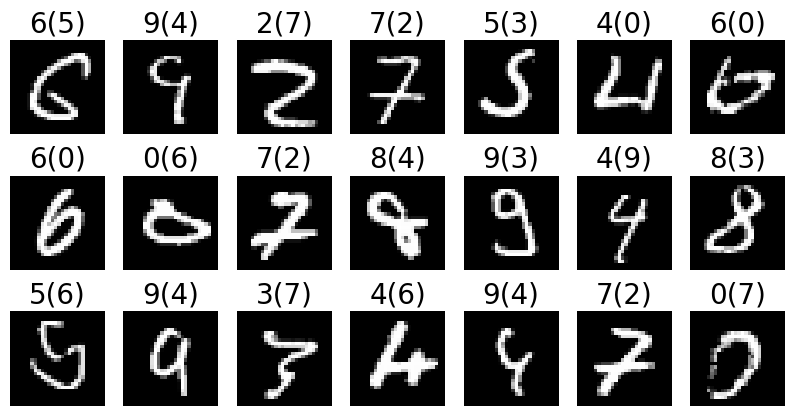

In [52]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

Ошибки наиболее часты с цифрами, которые похожи на другие, но в целом распределены по ним довольно равномерно (3, 4, 5, 6, 7, 9).

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [21]:
# !pip install scikit-image
from skimage.transform import rotate

transform_rotation = transforms.Compose([
                      transforms.RandomRotation(15),
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [22]:
train_dataset_rot = MNIST('.', train=True, download=True, transform=transform_rotation)
train_dataset_rot = TensorDataset(train_dataset_rot.train_data.to(DEVICE, dtype = torch.float),
                                  train_dataset_rot.train_labels.to(DEVICE))

train_loader_rot = DataLoader(train_dataset_rot, batch_size=32, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


epoch=0 train_loss=1.6600756523132325 train_accuracy=80.04166666666667
epoch=1 train_loss=1.6094874097824097 train_accuracy=85.125
epoch=2 train_loss=1.6030030366897583 train_accuracy=85.78
epoch=3 train_loss=1.598825940958659 train_accuracy=86.185
epoch=4 train_loss=1.5955229005813598 train_accuracy=86.535
epoch=5 train_loss=1.5671250826517742 train_accuracy=89.38666666666667
epoch=6 train_loss=1.5094194221496582 train_accuracy=95.14666666666666
epoch=7 train_loss=1.5020802050908406 train_accuracy=95.89
epoch=8 train_loss=1.5011430203119913 train_accuracy=96.0
epoch=9 train_loss=1.497710733795166 train_accuracy=96.33333333333333


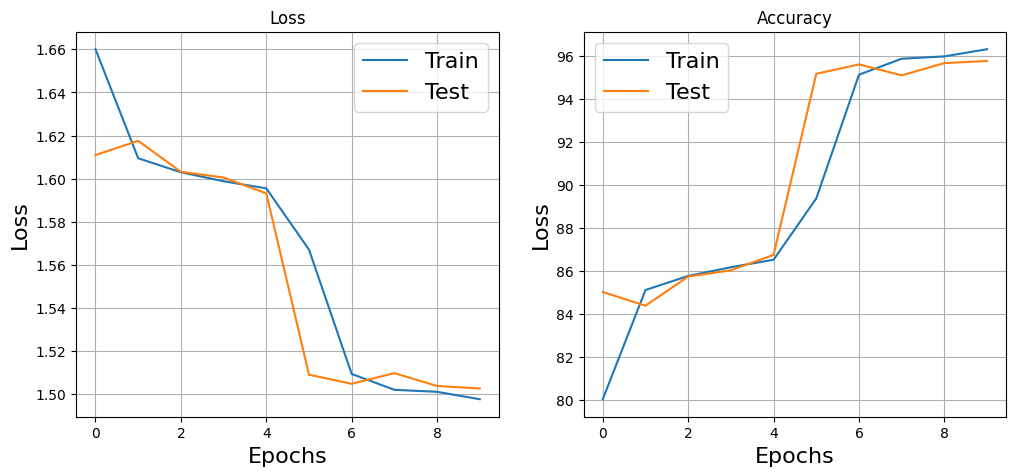

In [59]:
network_rot = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)
tr_rot, ts_rot, tr_ac_rot, ts_ac_rot = train_and_evaluate(network_rot,
                                                          train_loader_rot,
                                                          test_loader, NUM_EPOCHS, LEARNING_RATE/2)

In [24]:
transform_translation = transforms.Compose([
                          transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                        ])

In [25]:
train_dataset_tr = MNIST('.', train=True, download=True, transform=transform_translation)
train_dataset_tr = TensorDataset(train_dataset_tr.train_data.to(DEVICE, dtype = torch.float),
                                 train_dataset_tr.train_labels.to(DEVICE))

train_loader_tr = DataLoader(train_dataset_tr, batch_size=32, shuffle=True)

epoch=0 train_loss=1.6027497292200725 train_accuracy=85.82666666666667
epoch=1 train_loss=1.5235751151402792 train_accuracy=93.79
epoch=2 train_loss=1.5159357694625855 train_accuracy=94.51833333333333
epoch=3 train_loss=1.5083718830108643 train_accuracy=95.25333333333333
epoch=4 train_loss=1.5065439872105917 train_accuracy=95.42833333333333
epoch=5 train_loss=1.5028402657190958 train_accuracy=95.82666666666667
epoch=6 train_loss=1.5026518152236938 train_accuracy=95.83833333333334
epoch=7 train_loss=1.498295816230774 train_accuracy=96.27833333333334
epoch=8 train_loss=1.4983686641057332 train_accuracy=96.27
epoch=9 train_loss=1.4978445395787556 train_accuracy=96.315


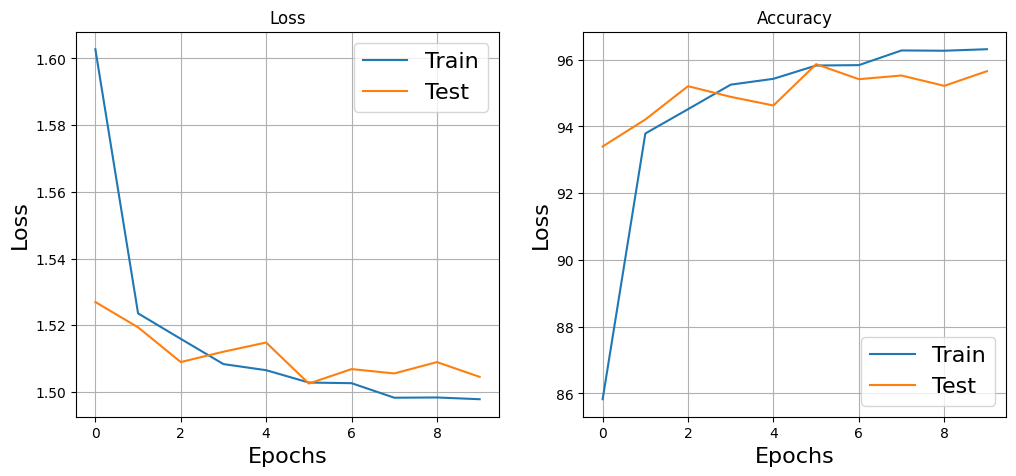

In [60]:
network_tr = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)
tr_tr, ts_tr, tr_ac_tr, ts_ac_tr = train_and_evaluate(network_tr,
                                                      train_loader_tr,
                                                      test_loader, NUM_EPOCHS, LEARNING_RATE/2)

In [27]:
from torch import Generator, rand

class GaussianNoiseTransform(object):
    """ adds normal (gaussian) noise"""
    def __init__(self, mean: float = 0., std: float = 1., initial_seed = None):
        self.std = std
        self.mean = mean
        self.generator = Generator()
        if initial_seed is not None:
          self.generator.manual_seed(initial_seed)

    def __call__(self, tensor):
        return tensor + rand(tensor.size(), generator = self.generator) * \
          self.std + self.mean

transform_noise = transforms.Compose([
                          GaussianNoiseTransform(),
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                        ])

In [28]:
train_dataset_n = MNIST('.', train=True, download=True, transform=transform_translation)
train_dataset_n = TensorDataset(train_dataset_n.train_data.to(DEVICE, dtype = torch.float),
                                train_dataset_n.train_labels.to(DEVICE))

train_loader_n = DataLoader(train_dataset_n, batch_size=32, shuffle=True)

epoch=0 train_loss=1.6959704955418904 train_accuracy=76.44833333333334
epoch=1 train_loss=1.6186805583318074 train_accuracy=84.21833333333333
epoch=2 train_loss=1.6089417346318562 train_accuracy=85.15333333333334
epoch=3 train_loss=1.548581688372294 train_accuracy=91.23166666666667
epoch=4 train_loss=1.5096784742355347 train_accuracy=95.12
epoch=5 train_loss=1.5041697535832723 train_accuracy=95.69166666666666
epoch=6 train_loss=1.5017642435709635 train_accuracy=95.91666666666667
epoch=7 train_loss=1.5008194054285686 train_accuracy=96.01333333333334
epoch=8 train_loss=1.4985618988672893 train_accuracy=96.255
epoch=9 train_loss=1.4982879014333088 train_accuracy=96.28833333333333


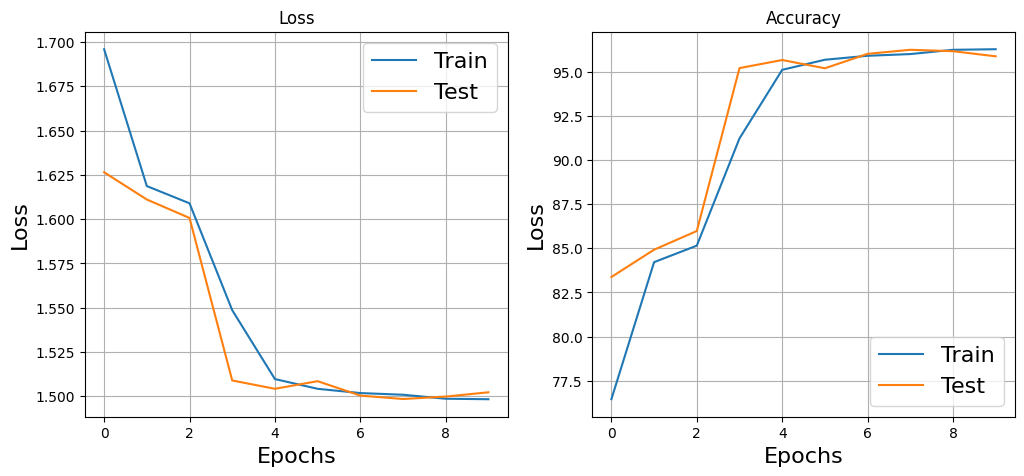

In [61]:
network_n = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)
tr_n, ts_n, tr_ac_n, ts_ac_n = train_and_evaluate(network_n,
                                                  train_loader_n,
                                                  test_loader, NUM_EPOCHS, LEARNING_RATE/2)

In [30]:
transform_all = transforms.Compose([
                          transforms.RandomAffine(degrees=15, translate=(0.05,0.05)),
                          GaussianNoiseTransform(),
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                        ])

In [31]:
train_dataset_all = MNIST('.', train=True, download=True, transform=transform_translation)
train_dataset_all = TensorDataset(train_dataset_all.train_data.to(DEVICE, dtype = torch.float),
                                  train_dataset_all.train_labels.to(DEVICE))

train_loader_all = DataLoader(train_dataset_all, batch_size=32, shuffle=True)

epoch=0 train_loss=1.7402274693806967 train_accuracy=71.97666666666667
epoch=1 train_loss=1.6994564711252849 train_accuracy=76.09333333333333
epoch=2 train_loss=1.6932805099487305 train_accuracy=76.745
epoch=3 train_loss=1.6246470249811809 train_accuracy=83.60333333333334
epoch=4 train_loss=1.6027876735051474 train_accuracy=85.79
epoch=5 train_loss=1.5964812962849935 train_accuracy=86.42166666666667
epoch=6 train_loss=1.5862011156082154 train_accuracy=87.45666666666666
epoch=7 train_loss=1.5079705955505371 train_accuracy=95.31833333333333
epoch=8 train_loss=1.5029850660324098 train_accuracy=95.8
epoch=9 train_loss=1.5007416310628254 train_accuracy=96.03166666666667


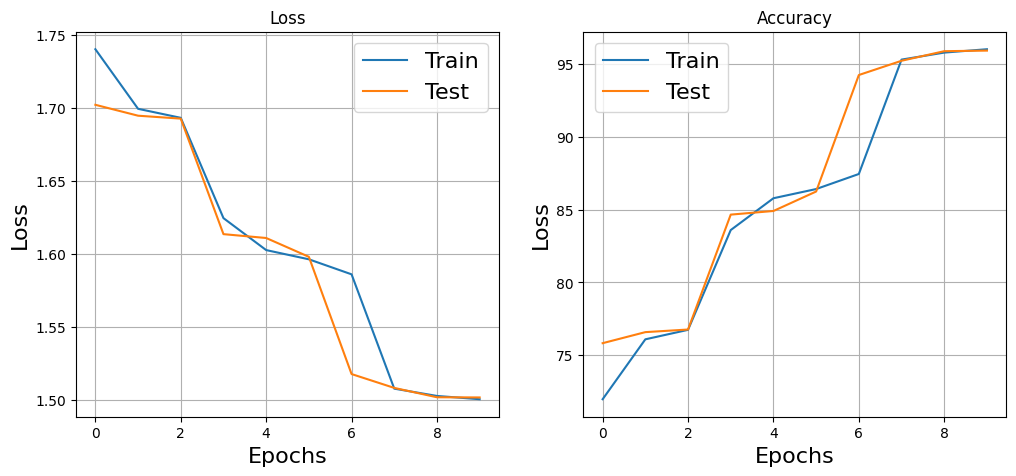

In [62]:
network_all = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)
tr_all, ts_all, tr_ac_all, ts_ac_all = train_and_evaluate(network_all,
                                                  train_loader_all,
                                                  test_loader, NUM_EPOCHS, LEARNING_RATE/2)

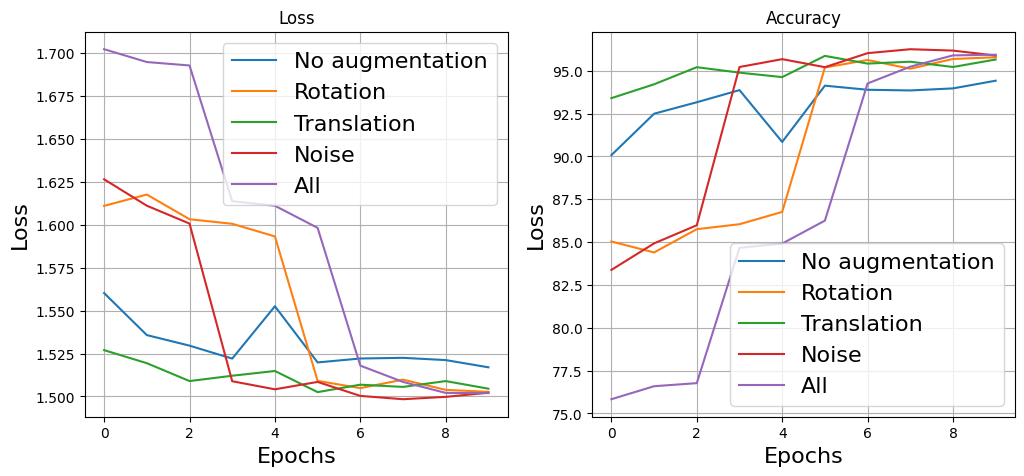

In [63]:
plot_train_results(loss_results=[ts_r, ts_rot, ts_tr, ts_n, ts_all],
                        acc_results=[ts_ac_r, ts_ac_rot, ts_ac_tr, ts_ac_n, ts_ac_all],
                        labels=["No augmentation", "Rotation", "Translation", "Noise", "All"])

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

ELU и ReLU показали лучшею и более быструю сходимость. Однако стоит отметить, что с оптимизатором adam pytorch показывает гораздо более хорошие результаты с learning rate гораздо меньше 0.01 (как с встроенными функциями активации, так и с самодельными. При этом ReLU и ELU с 0.01 показывали точность обычно порядка 40%, а при 0.001 сильно зависили от инициализации).

Случайные сдвиги и повороты также улучшают качество модели на тестовой выборке, что и ожидалось.
Случайный шум также улучшает качество обучения.
Использование всех аугментаций не увеличило значительно качества относительно отдельных.

Однако стоит отметить, что для качественного анализа требуется проведение множества исследований, т.к. результат сильно зависит от начального качества системы, конкретеного положения в данный момент (грубо говоря, качество может быть не очень, зато производная большая и близко находится к "глубокому" локальному минимуму).